In [1]:
import os

import syft as sy
import pandas as pd
import numpy as np
import torch

import monai
from monai.data import ImageDataset
from monai.transforms import AddChannel, Compose, RandRotate90, Resize, ScaleIntensity, ToTensor

# 1. Launch Duet Session

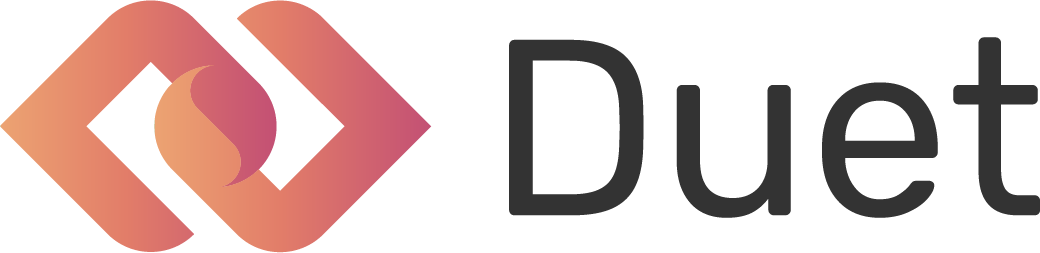

🎤  🎸  ♪♪♪ Starting Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-218-7-180.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!

♫♫♫ > STEP 1: Send the following code to your Duet Partner!

import syft as sy
duet = sy.join_duet(loopback=True)

♫♫♫ > Connecting...

♫♫♫ > CONNECTED!

♫♫♫ > DUET LIVE STATUS  *  Objects: 0  Requests: 0   Messages: 0  Request Handlers: 0                                torch.Size([4, 1, 96, 96, 96])
torch.Size([4])


In [2]:
duet = sy.launch_duet(loopback=True)#network_url='http://ec2-18-218-7-180.us-east-2.compute.amazonaws.com:5000/')

# 3. Upload Data to Duet Server

## 3.0 Get Data

In [3]:
# Set to true if Data was not downloaded yet. Set to false afterwards!
# 4.5 GB / ~ 600 Pictures (3D) / 1 excel file for labels
DOWNLOAD = False

if DOWNLOAD:
    data_url = 'http://biomedic.doc.ic.ac.uk/brain-development/downloads/IXI/IXI-T1.tar'
    compressed_file = os.sep.join(['Data', 'IXI-T1.tar'])
    data_dir = os.sep.join(['Data', 'IXI-T1'])
    
    # Data download
    monai.apps.download_and_extract(data_url, compressed_file, './Data/IXI-T1')

    # Labels document download
    labels_url = 'http://biomedic.doc.ic.ac.uk/brain-development/downloads/IXI/IXI.xls'
    monai.apps.download_url(labels_url, './Data/IXI.xls')

## 3.1 Construct labeled Dataset

In [4]:
images = [impath for impath in os.listdir('./Data/IXI-T1')]

demographic_info = pd.read_excel('./Data/IXI.xls')

# Getting lables TODO: Implement multiple possible labels, not just sex.
def make_labeled_data(df, images):
    data = []
    labels = []
    for i in images:
        ixi_id = int(i[3:6])
        row = df.loc[df['IXI_ID'] == ixi_id]
        if not row.empty:
            data.append(os.sep.join(['Data', 'IXI-T1', i]))
            labels.append(row.iat[0, 1] - 1) # Sex labels are 1/2 but need to be 0/1
         
    return data, labels


data, labels = make_labeled_data(demographic_info, images)

SAMPLE_SIZE = 4/566

data, labels = data[:int(len(data) * SAMPLE_SIZE)], labels[:int(len(data) * SAMPLE_SIZE)]

# Specify transforms
transforms = Compose([ScaleIntensity(), AddChannel(), Resize((96, 96, 96))])

# Create DataSet
ds = ImageDataset(image_files=data, transform=transforms, shuffle=False)
data_tensor = torch.Tensor(ds)
labels_tensor = torch.Tensor(labels)
print(data_tensor.shape)
print(labels_tensor.shape)

## 3.2 Upload Data to Duet server

In [5]:
# Describe the data
data_tensor = data_tensor.describe(f"This is a dataset of 3D brain MRI images. Contains {len(data)} images.")
data_tensor = data_tensor.tag('IXI-T1-data')
data_tensor = data_tensor.send(duet, pointable=True)

labels_tensor = labels_tensor.describe("Labels: 0 (male), 1 (female)")
labels_tensor = labels_tensor.tag('IXI-T1-labels')
labels_tensor = labels_tensor.send(duet, pointable=True)

In [6]:
duet.store.pandas

,ID,Tags,Description,object_type
0,<UID: 903b96e98837400488d54fbb559899e2>,[IXI-T1-data],This is a dataset of 3D brain MRI images. Cont...,<class 'torch.Tensor'>
1,<UID: 4642724b58154b179321b8be8583ccc8>,[IXI-T1-labels],"Labels: 0 (male), 1 (female)",<class 'torch.Tensor'>


In [7]:
duet.requests.add_handler(action="accept")

[2021-05-26T12:34:01.793307+0200][CRITICAL][logger]][19864] ceil() missing 1 required positional arguments: "input"
[2021-05-26T12:34:01.794308+0200][CRITICAL][logger]][19864] ceil() missing 1 required positional arguments: "input"
Exception in callback AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ts: "input"')>) at C:\Users\Adrian\miniconda3\envs\seminar\lib\site-packages\pyee\_asyncio.py:55
handle: <Handle AsyncIOEventEmitter._emit_run.<locals>._callback(<Task finishe...ts: "input"')>) at C:\Users\Adrian\miniconda3\envs\seminar\lib\site-packages\pyee\_asyncio.py:55>
Traceback (most recent call last):
  File "C:\Users\Adrian\miniconda3\envs\seminar\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Adrian\miniconda3\envs\seminar\lib\site-packages\pyee\_asyncio.py", line 62, in _callback
    self.emit('error', exc)
  File "C:\Users\Adrian\miniconda3\envs\seminar\lib\site-packages\pyee\_base.py", line 116, in 